In [34]:
import pandas as pd
from datetime import datetime

In [35]:
df_24 = pd.read_csv('fc24_dataframe.csv')

df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)

df_24 = df_24.drop('name', axis=1)
df_24 = df_24.drop('acceleration', axis=1)
df_24 = df_24.drop('sprint_speed', axis=1)
df_24 = df_24.drop('att_position', axis=1)
df_24 = df_24.drop('finishing', axis=1)
df_24 = df_24.drop('shot_power', axis=1)
df_24 = df_24.drop('long_shots', axis=1)
df_24 = df_24.drop('volleys', axis=1)
df_24 = df_24.drop('penalties', axis=1)
df_24 = df_24.drop('vision', axis=1)
df_24 = df_24.drop('crossing', axis=1)
df_24 = df_24.drop('fk_accuracy', axis=1)
df_24 = df_24.drop('short_pass', axis=1)
df_24 = df_24.drop('long_pass', axis=1)
df_24 = df_24.drop('curve', axis=1)
df_24 = df_24.drop('agility', axis=1)
df_24 = df_24.drop('balance', axis=1)
df_24 = df_24.drop('reactions', axis=1)
df_24 = df_24.drop('ball_control', axis=1)
df_24 = df_24.drop('dribbling', axis=1)
df_24 = df_24.drop('composure', axis=1)
df_24 = df_24.drop('interceptions', axis=1)
df_24 = df_24.drop('heading_acc', axis=1)
df_24 = df_24.drop('def_aware', axis=1)
df_24 = df_24.drop('stand_tackle', axis=1)
df_24 = df_24.drop('slide_tackle', axis=1)
df_24 = df_24.drop('jumping', axis=1)
df_24 = df_24.drop('stamina', axis=1)
df_24 = df_24.drop('strength', axis=1)
df_24 = df_24.drop('aggression', axis=1)
df_24 = df_24.drop('body_type', axis=1)
df_24 = df_24.drop('accelerate', axis=1)
df_24 = df_24.drop('card_page_url', axis=1)
df_24 = df_24.drop('positions', axis=1)
df_24 = df_24.drop('playstyles', axis=1)
df_24 = df_24.drop('weight', axis=1)

# Ensure 'date' column is in datetime format
df_24['date'] = pd.to_datetime(df_24['date'])

In [39]:
df_24.columns

Index(['card_id', 'rating', 'skill_moves', 'weak_foot', 'pace_m', 'shooting_m',
       'passing_m', 'dribbling_m', 'defending_m', 'physical_m', 'height',
       'total_ingame_stats', 'nation', 'league', 'club', 'intl_rep', 'date',
       'price', 'days_since_start', 'days_until_end', 'days_since_release',
       'price_pct_change'],
      dtype='object')

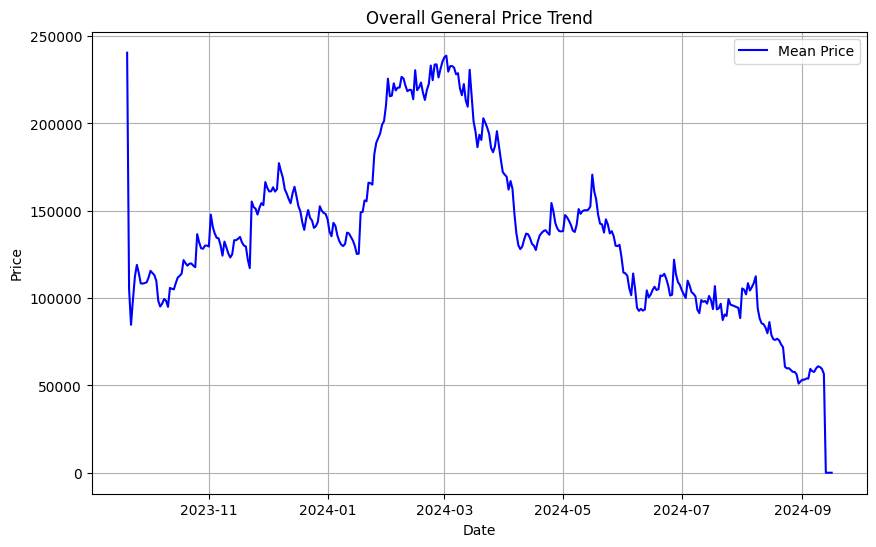

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate prices by date
aggregated = df_24.groupby('date')['price'].mean().reset_index()

# Plot the general trend
plt.figure(figsize=(10, 6))
plt.plot(aggregated['date'], aggregated['price'], label='Mean Price', color='blue')
plt.title('Overall General Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_24.isnull().sum()

In [38]:
# Get start and end dates of the game cycle
fc24_start_date = df_24['date'].min()
fc24_end_date = df_24['date'].max()

# Compute days_since_start and days_until_end based on FC24 game cycle
df_24['days_since_start'] = (df_24['date'] - fc24_start_date).dt.days
df_24['days_until_end'] = (fc24_end_date - df_24['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_24.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_24 = df_24.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_24['days_since_release'] = (df_24['date'] - df_24['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_24 = df_24.drop(columns=['release_date'])

# Remove rows with price = 0
df_24 = df_24[df_24['price'] > 0].reset_index(drop=True)

# Step 1: Calculate price at t+7 for each card_id
df_24['price_t_plus_7'] = df_24.groupby('card_id')['price'].shift(-7)

# Step 2: Compute percentage change between t and t+7
df_24['price_pct_change'] = (df_24['price_t_plus_7'] - df_24['price']) / df_24['price']

# Step 3: Drop rows where t+7 price is NaN (cannot calculate percentage change)
df_24 = df_24.dropna(subset=['price_pct_change']).reset_index(drop=True)

# Step 4: Drop intermediate column if no longer needed
df_24 = df_24.drop(columns=['price_t_plus_7'])

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_24)}")

# Step 2: Sort and Prepare Data
df_24['date'] = pd.to_datetime(df_24['date'])  # Ensure date is datetime
df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_24['height'] = df_24['height'].fillna(df_24['height'].median())
df_24['nation'] = df_24['nation'].fillna('Unknown')
df_24['league'] = df_24['league'].fillna('Unknown')
df_24['club'] = df_24['club'].fillna('Unknown')
df_24['intl_rep'] = df_24['intl_rep'].fillna(1)

Number of rows after removing 0 price: 1046517


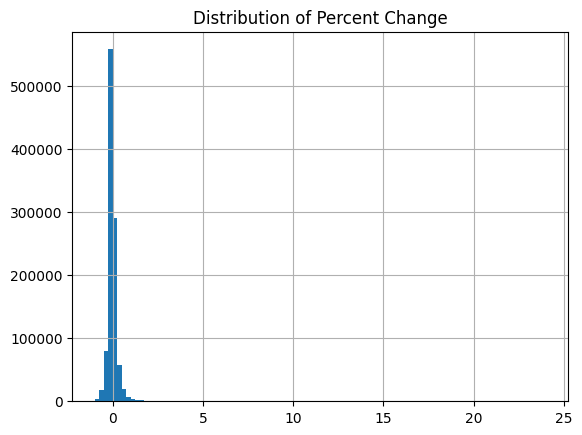

In [42]:
import matplotlib.pyplot as plt
df_24['price_pct_change'].hist(bins=100)
plt.title('Distribution of Percent Change')
plt.show()

In [41]:
# Remove rows where percent_change_7_days is greater than 110%
df_24 = df_24[df_24['price_pct_change'] <= 100].reset_index(drop=True)

# Verify the updated DataFrame
print(f"Number of rows after removal: {len(df_24)}")

Number of rows after removal: 1046510


In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
le_nation = LabelEncoder()
le_league = LabelEncoder()
le_club = LabelEncoder()

# Apply label encoding to each categorical column
df_24['nation'] = le_nation.fit_transform(df_24['nation'].astype(str))
df_24['league'] = le_league.fit_transform(df_24['league'].astype(str))
df_24['club'] = le_club.fit_transform(df_24['club'].astype(str))

# Verify encoding
print("Unique values in 'nation':", len(le_nation.classes_))
print("Unique values in 'league':", len(le_league.classes_))
print("Unique values in 'club':", len(le_club.classes_))

Unique values in 'nation': 99
Unique values in 'league': 45
Unique values in 'club': 263


In [44]:
import numpy as np

# Define look-back and look-ahead
look_back = 7
look_ahead = 7

# Function to create time-series sequences
def create_sequences(data, look_back, look_ahead, input_cols, target_col):
    X, y, card_ids = [], [], []  # Include card_id in the output
    for card_id, group in data.groupby('card_id'):  # Group by card_id
        group = group.sort_values('date')  # Ensure sorted by date
        features = group[input_cols].values
        target = group[target_col].values
        
        # Sliding window logic
        for i in range(len(features) - look_back - look_ahead + 1):
            X.append(features[i:i + look_back])  # Look-back window for features
            y.append(target[i + look_back + look_ahead - 1])  # Target after 7 days
            card_ids.append(card_id)  # Track card_id for each sequence

    return np.array(X), np.array(y), np.array(card_ids)

# Define input and target columns
input_cols = [col for col in df_24.columns if col not in ['date', 'price_pct_change']]  # Keep 'card_id'
target_col = 'price_pct_change'

# Create sequences
X, y, card_ids = create_sequences(df_24, look_back, look_ahead, input_cols, target_col)

# Check shapes
print(f"Shape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of y (samples,): {y.shape}")
print(f"Shape of card_ids (samples,): {card_ids.shape}")

Shape of X (samples, timesteps, features): (1003727, 7, 20)
Shape of y (samples,): (1003727,)
Shape of card_ids (samples,): (1003727,)


In [45]:
# Check for NaN values in X
X_null = np.isnan(X).any(axis=(1, 2))  # Check across all timesteps and features for each sample

# How many rows have NaN?
print(f"Number of rows with NaN in X: {np.sum(X_null)}")

# Optionally, get indices of rows with NaN
X_null_indices = np.where(X_null)[0]
print(f"Indices of rows with NaN in X: {X_null_indices[:10]}")  # Show first 10 indices

Number of rows with NaN in X: 0
Indices of rows with NaN in X: []


In [46]:
# Check for NaN in y
y_null = np.isnan(y)
print(f"Number of rows with NaN in y: {np.sum(y_null)}")

Number of rows with NaN in y: 0


In [47]:
# Shape of the first sample
print(f"Shape of X[0]: {X[2].shape}")

Shape of X[0]: (7, 20)


In [48]:
from sklearn.model_selection import train_test_split

# Step 1: Get unique card_ids
unique_card_ids = np.unique(card_ids)

# Step 2: Split card_ids into training, validation, and test sets
train_card_ids, test_card_ids = train_test_split(unique_card_ids, test_size=0.15, random_state=42)
train_card_ids, val_card_ids = train_test_split(train_card_ids, test_size=0.1765, random_state=42)  # ~15% of remaining

# Step 3: Create masks to filter sequences
train_mask = np.isin(card_ids, train_card_ids)
val_mask = np.isin(card_ids, val_card_ids)
test_mask = np.isin(card_ids, test_card_ids)

# Step 4: Split X, y, and card_ids based on masks
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Check shapes
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (707160, 7, 20), (707160,)
Validation set shape: (144155, 7, 20), (144155,)
Test set shape: (152412, 7, 20), (152412,)


In [49]:
from sklearn.preprocessing import MinMaxScaler

# Indices of categorical features
categorical_indices = [input_cols.index('nation'), input_cols.index('league'), input_cols.index('club')]

# Create mask for numerical features
numerical_mask = np.ones(X_train.shape[-1], dtype=bool)
numerical_mask[categorical_indices] = False  # Exclude categorical features

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape numerical features for scaling
X_train_numerical = X_train[:, :, numerical_mask].reshape(-1, X_train.shape[-1] - len(categorical_indices))
X_val_numerical = X_val[:, :, numerical_mask].reshape(-1, X_train.shape[-1] - len(categorical_indices))
X_test_numerical = X_test[:, :, numerical_mask].reshape(-1, X_train.shape[-1] - len(categorical_indices))

# Scale numerical features
X_train_scaled_numerical = scaler_X.fit_transform(X_train_numerical).reshape(X_train.shape[0], X_train.shape[1], -1)
X_val_scaled_numerical = scaler_X.transform(X_val_numerical).reshape(X_val.shape[0], X_val.shape[1], -1)
X_test_scaled_numerical = scaler_X.transform(X_test_numerical).reshape(X_test.shape[0], X_test.shape[1], -1)

# Combine scaled numerical features with categorical features
X_train_scaled = np.concatenate([X_train_scaled_numerical, X_train[:, :, categorical_indices]], axis=-1)
X_val_scaled = np.concatenate([X_val_scaled_numerical, X_val[:, :, categorical_indices]], axis=-1)
X_test_scaled = np.concatenate([X_test_scaled_numerical, X_test[:, :, categorical_indices]], axis=-1)

# Scale target values
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Print scaled shapes
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

X_train_scaled shape: (707160, 7, 20)
y_train_scaled shape: (707160,)


In [50]:
# Find the index of 'card_id' in the input columns
card_id_index = input_cols.index('card_id')

# Remove 'card_id' from the input features
X_train_scaled = np.delete(X_train_scaled, card_id_index, axis=-1)
X_val_scaled = np.delete(X_val_scaled, card_id_index, axis=-1)
X_test_scaled = np.delete(X_test_scaled, card_id_index, axis=-1)

# Verify shapes after removing 'card_id'
print(f"X_train_scaled shape after removing card_id: {X_train_scaled.shape}")
print(f"X_val_scaled shape after removing card_id: {X_val_scaled.shape}")
print(f"X_test_scaled shape after removing card_id: {X_test_scaled.shape}")

X_train_scaled shape after removing card_id: (707160, 7, 19)
X_val_scaled shape after removing card_id: (144155, 7, 19)
X_test_scaled shape after removing card_id: (152412, 7, 19)


In [51]:
# FIRST ARCHITECTURE: FULLY CONNECTED DNN 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Define the DNN model
dnn_model = Sequential([
    Flatten(input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),  # Flatten (timesteps, features)
    Dense(128, activation='relu'),  # First dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),  # Second dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(1)  # Output layer for regression
])

# Compile the model
dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
print(dnn_model.summary())

/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,473 (99.50 KB)

 Trainable params: 25,473 (99.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.3008e-04 - mae: 0.0069 - val_loss: 5.4906e-04 - val_mae: 0.0072
Epoch 2/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 3.0869e-04 - mae: 0.0069 - val_loss: 5.4402e-04 - val_mae: 0.0074
Epoch 3/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.0596e-04 - mae: 0.0069 - val_loss: 5.4695e-04 - val_mae: 0.0071
Epoch 4/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.0283e-04 - mae: 0.0069 - val_loss: 5.4389e-04 - val_mae: 0.0075
Epoch 5/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 3.1909e-04 - mae: 0.0069 - val_loss: 5.4721e-04 - val_mae: 0.0071
Epoch 6/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.0783e-04 - mae: 0.0069 - val_loss: 5.4410e-04 - val_mae: 0.0073
Epoch 7/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 3.1806e-04 - mae: 0.0069 - val_loss: 5.4417e-04 - val_mae: 0.0077
Epoch 8/13
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 3.1449e-04 - mae: 

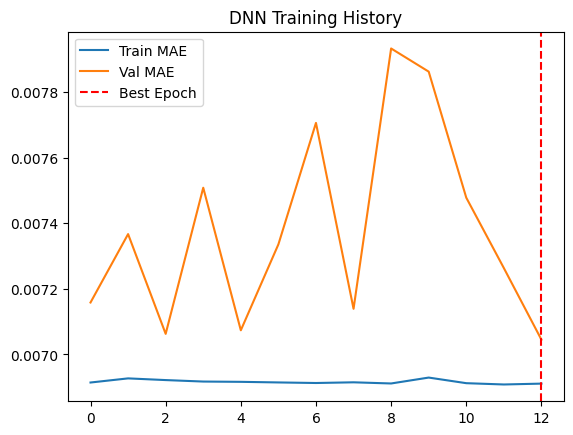

In [53]:
# Train the DNN model
history_dnn = dnn_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=13,  # Train for 150 epochs
    batch_size=64,
    verbose=1
)

# Find the epoch with the lowest validation MAE
best_epoch = np.argmin(history_dnn.history['val_mae']) + 1  # Add 1 because epochs are 0-indexed
best_val_mae = history_dnn.history['val_mae'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Validation MAE at Best Epoch: {best_val_mae:.4f}")

# Plot training and validation MAE
import matplotlib.pyplot as plt

plt.plot(history_dnn.history['mae'], label='Train MAE')
plt.plot(history_dnn.history['val_mae'], label='Val MAE')
plt.axvline(best_epoch - 1, color='red', linestyle='--', label='Best Epoch')
plt.legend()
plt.title('DNN Training History')
plt.show()

In [57]:
# Step 1: Predict on the test set
y_pred_scaled = dnn_model.predict(X_test_scaled)

# Step 2: Unnormalize predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

4763/4763 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


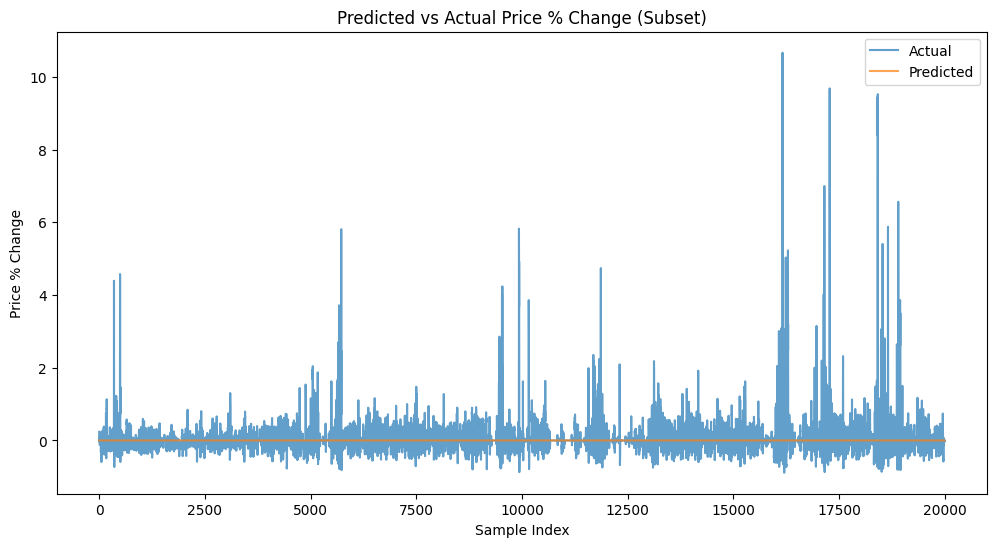

Mean Absolute Error (MAE): 0.1599
Mean Squared Error (MSE): 0.1790
R² Score: -0.0046


In [58]:
# Step 3: Visualize predictions vs actual values
import matplotlib.pyplot as plt

# Plot for a subset of the data (e.g., first 200 points)
plt.figure(figsize=(12, 6))
plt.plot(y_actual[:20000], label='Actual', alpha=0.7)
plt.plot(y_pred[:20000], label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual Price % Change (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Price % Change')
plt.legend()
plt.show()

# Optional: Calculate metrics on test data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout

# Build the CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print summary
print(model_cnn.summary())

/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,065 (47.13 KB)

 Trainable params: 12,065 (47.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [60]:
# Train the model
history_cnn = model_cnn.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=128,
    verbose=1
)

# Save the training history for future reference
# cnn_history = history_cnn.history

Epoch 1/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 1.1595 - mae: 0.2134 - val_loss: 5.4389e-04 - val_mae: 0.0075
Epoch 2/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.2851e-04 - mae: 0.0069 - val_loss: 5.4511e-04 - val_mae: 0.0071
Epoch 3/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 3.0775e-04 - mae: 0.0069 - val_loss: 5.4397e-04 - val_mae: 0.0074
Epoch 4/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 3.1407e-04 - mae: 0.0069 - val_loss: 5.4584e-04 - val_mae: 0.0071
Epoch 5/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.1874e-04 - mae: 0.0069 - val_loss: 5.4679e-04 - val_mae: 0.0071
Epoch 6/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 3.1740e-04 - mae: 0.0069 - val_loss: 5.4389e-04 - val_mae: 0.0075
Epoch 7/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.1132e-04 - mae: 0.0069 - val_loss: 5.4500e-04 - val_mae: 0.0072
Epoch 8/20
5525/5525 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 3.1955e-04 - mae: 0.0069 - val_loss: 5

In [63]:
# Save the training history for future reference
cnn_history = history_cnn.history

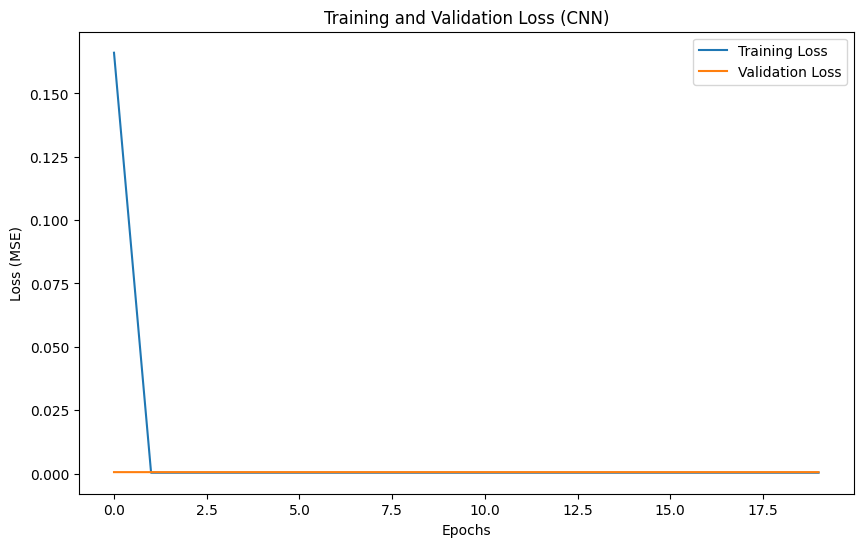

In [64]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(cnn_history['loss'], label='Training Loss')
plt.plot(cnn_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

4763/4763 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


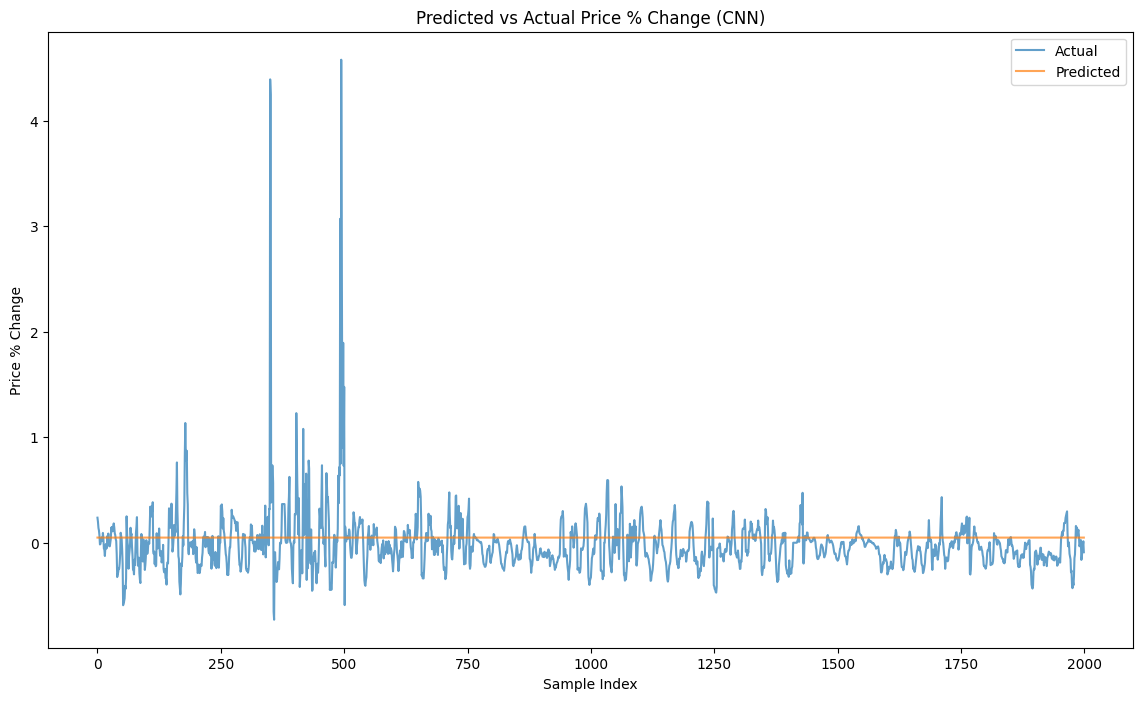

In [65]:
# Generate predictions on the test set
y_test_pred_scaled = model_cnn.predict(X_test_scaled)

# Unscale the predictions and actual values
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Plot predictions vs actual values for a subset of data
plt.figure(figsize=(14, 8))
plt.plot(y_test_actual[:2000], label='Actual', alpha=0.7)
plt.plot(y_test_pred[:2000], label='Predicted', alpha=0.7)
plt.title('Predicted vs Actual Price % Change (CNN)')
plt.xlabel('Sample Index')
plt.ylabel('Price % Change')
plt.legend()
plt.show()

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the RNN model
model_rnn = Sequential([
    GRU(64, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

# Compile the model
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print summary
print(model_rnn.summary())

/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        16,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [67]:
# Train the RNN model
history_rnn = model_rnn.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 0.0067 - mae: 0.0248 - val_loss: 5.4559e-04 - val_mae: 0.0081
Epoch 2/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 3.0132e-04 - mae: 0.0069 - val_loss: 5.4405e-04 - val_mae: 0.0077
Epoch 3/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 3.0451e-04 - mae: 0.0069 - val_loss: 5.4392e-04 - val_mae: 0.0074
Epoch 4/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 3.1768e-04 - mae: 0.0069 - val_loss: 5.4389e-04 - val_mae: 0.0075
Epoch 5/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 3.0372e-04 - mae: 0.0069 - val_loss: 5.4740e-04 - val_mae: 0.0071
Epoch 6/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 3.1653e-04 - mae: 0.0069 - val_loss: 5.4919e-04 - val_mae: 0.0072
Epoch 7/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - loss: 3.1788e-04 - mae: 0.0069 - val_loss: 5.4410e-04 - val_mae: 0.0077
Epoch 8/20
11050/11050 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - loss: 3.0826e-04 - mae: 0.00